In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import quad
import seaborn as sns
from matplotlib.colors import LogNorm
import pickle

In [2]:
# Define the folders and the file names to be processed
folder = "WithAm_N_2.5bar_14.0deg_NoAmp/"
outplotdir= "../Analized/An_V5_pel_fan/Results_Am_N_2.5bar_20.5deg/"

# Check if the directory exists
if not os.path.exists(outplotdir):
    # Create the directory
    os.makedirs(outplotdir)
    print(f"Directory {outplotdir} created.")
else:
    print(f"Directory {outplotdir} already exists.")

# Initialize empty lists to hold DataFrames for each folder
dataframe_sig = []

countersig=0

# Process each folder

file_names = [file for file in os.listdir(folder) if file.endswith('.csv')]

for file_name in file_names:
    file_path = os.path.join(folder, file_name)
    df = pd.read_csv(file_path)
    dataframe_sig.append(df)
    countersig+=1
            
# Concatenate all DataFrames in each list into one DataFrame for each folder
df_sig = pd.concat(dataframe_sig, ignore_index=True)

Directory ../Analized/An_V5_pel_fan/Results_Am_N_2.5bar_20.5deg/ already exists.


In [3]:
df_sig.head()

,Unnamed: 0,event,channel,time,time_len,integral,ampl,npeaks,is_sat
0,0,0,CH1,-1.934485e-06,1.760000e-07,6.489885e-11,0.000678,1.0,False
1,1,0,CH1,-1.196885e-06,3.088000e-07,1.189395e-10,0.000853,1.0,False
2,2,0,CH1,-1.952850e-07,1.488000e-07,5.449700e-11,0.000613,0.0,False
3,3,0,CH1,-3.688500e-08,2.408000e-06,4.279459e-09,0.008876,7.0,False
4,4,0,CH1,2.372715e-06,1.600000e-09,0.000000e+00,NaN,0.0,False


In [4]:
fscalesig = (countersig-1)*2000+df_sig['event'].iloc[-1]

print(fscalesig)

df_sig = df_sig.drop(columns=['Unnamed: 0'])
df_sig['event']=df_sig['event'].ne(df_sig['event'].shift()).cumsum()

43999


In [5]:
df_sig.head()

,event,channel,time,time_len,integral,ampl,npeaks,is_sat
0,1,CH1,-1.934485e-06,1.760000e-07,6.489885e-11,0.000678,1.0,False
1,1,CH1,-1.196885e-06,3.088000e-07,1.189395e-10,0.000853,1.0,False
2,1,CH1,-1.952850e-07,1.488000e-07,5.449700e-11,0.000613,0.0,False
3,1,CH1,-3.688500e-08,2.408000e-06,4.279459e-09,0.008876,7.0,False
4,1,CH1,2.372715e-06,1.600000e-09,0.000000e+00,NaN,0.0,False


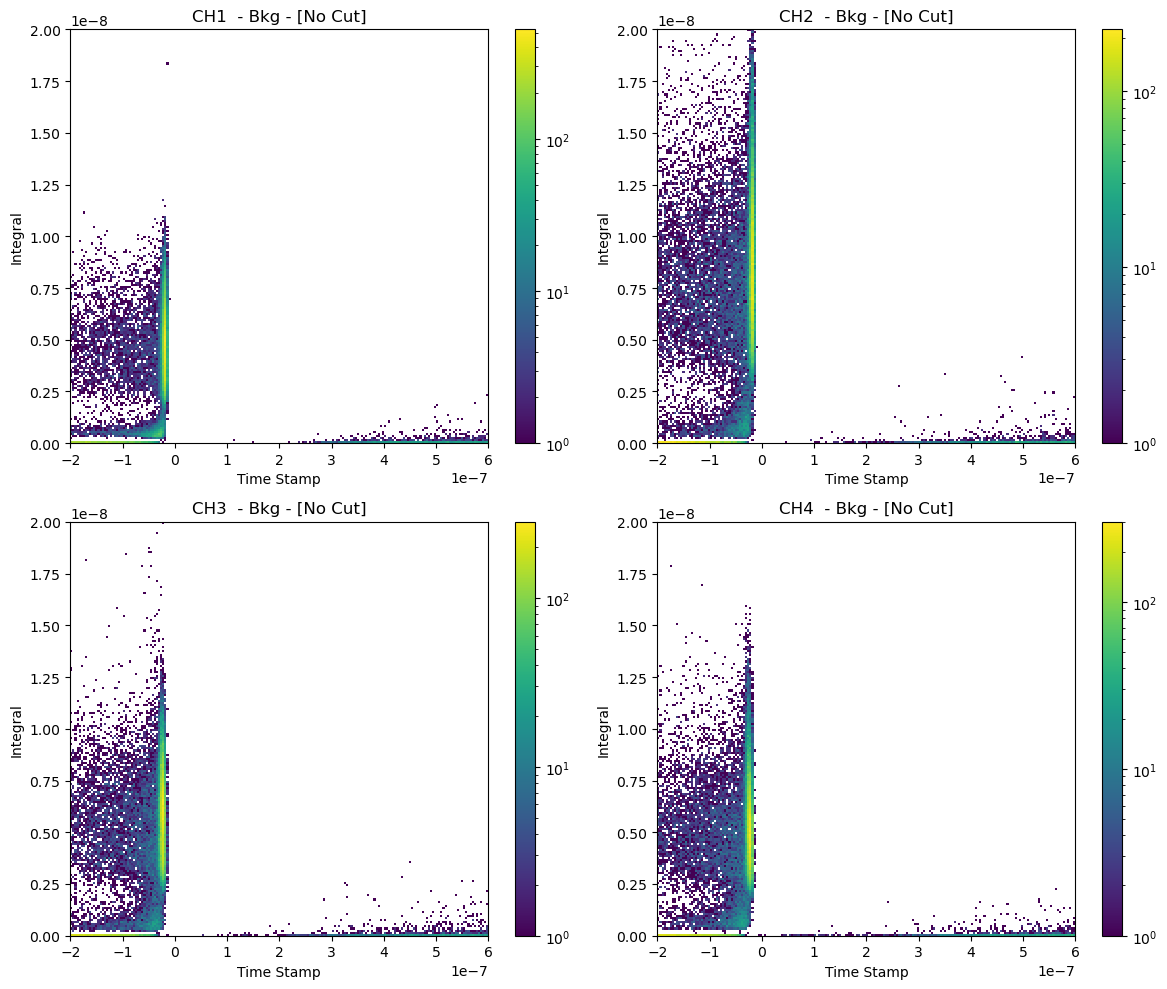

In [6]:
# Unique channels in the data
channels = df_sig['channel'].unique()

# Create a figure with 4 subplots (2x2 layout)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Define the number of bins for the histogram
num_bins = 200

# Plot 2D histogram for 'integral' vs 'time' for each channel
for i, channel in enumerate(channels):
    ax = axs[i // 2, i % 2]  # Determine the subplot index
    channel_data = df_sig[df_sig['channel'] == channel]  # Filter data for the channel
    
    # Create 2D histogram
    h = ax.hist2d(channel_data['time'], channel_data['integral'], bins=num_bins,range=[(-2e-7,6e-7),(0,2.0e-8)], cmap='viridis', norm=colors.LogNorm())
    
    # Add colorbar
    plt.colorbar(h[3], ax=ax)
    
    ax.set_title(f'{channel}  - Bkg - [No Cut]')
    ax.set_xlabel('Time Stamp')
    ax.set_ylabel('Integral')
    #ax.set_ylim([0,10])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

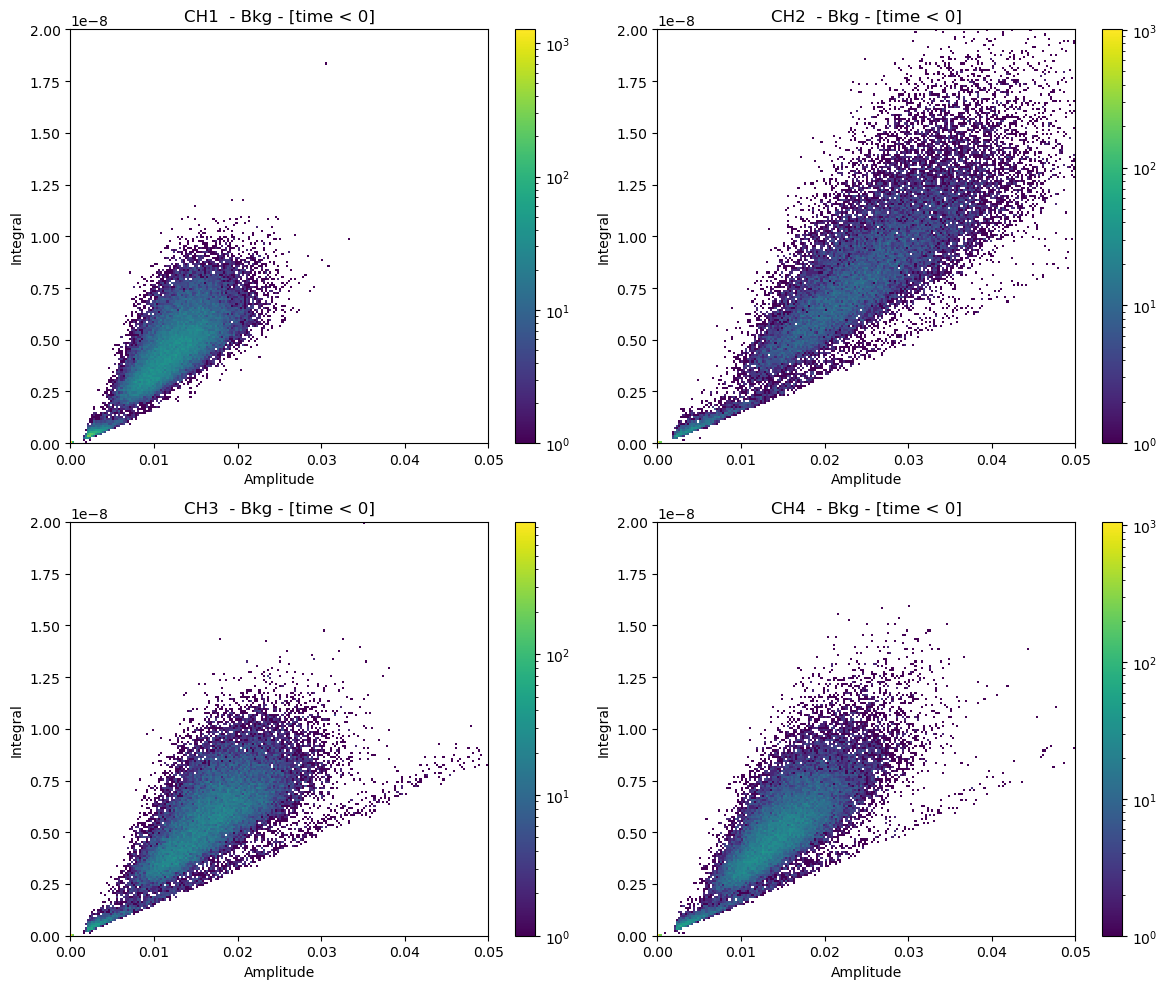

In [7]:
# Unique channels in the data
channels = df_sig['channel'].unique()

# Create a figure with 4 subplots (2x2 layout)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Define the number of bins for the histogram
num_bins = 200

# Plot 2D histogram for 'integral' vs 'time' for each channel
for i, channel in enumerate(channels):
    ax = axs[i // 2, i % 2]  # Determine the subplot index
    channel_data = df_sig[(df_sig['channel'] == channel) & (df_sig['time']<0) & (df_sig['time']>-1e-7)]  # Filter data for the channel
    
    # Create 2D histogram
    h = ax.hist2d(channel_data['ampl'], channel_data['integral'], bins=num_bins,range=[(0,5e-2), (0,2.0e-8)], cmap='viridis', norm=colors.LogNorm())
    
    # Add colorbar
    plt.colorbar(h[3], ax=ax)
    
    ax.set_title(f'{channel}  - Bkg - [time < 0]')
    ax.set_xlabel('Amplitude')
    ax.set_ylabel('Integral')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

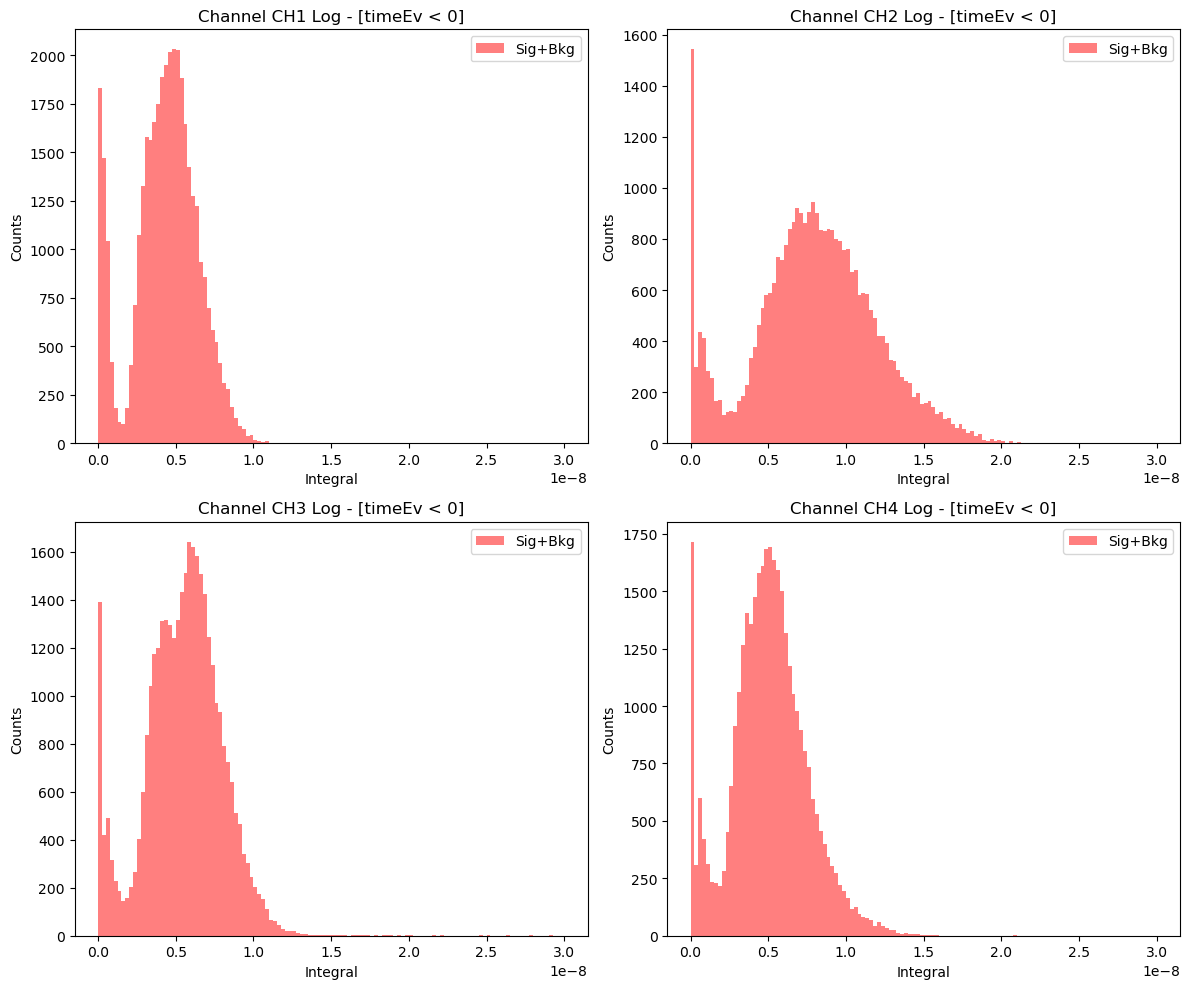

In [8]:
# Unique channels in the data
channels = df_sig['channel'].unique()

# Create a figure with 4 subplots (2x2 layout)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Define the number of bins for the histogram
bins = [120, 120, 120, 120]
a_range = [0,3.0e-8]

histogram_data = {}

# Plot for each channel with background and signal superimposed
for i, channel in enumerate(channels):
    ax = axs[i // 2, i % 2]  # Determine the subplot index
    
    # Signal data selection
    channel_data_signal = df_sig[(df_sig['channel'] == channel) & (df_sig['time'] < 0) &  (df_sig['time']>-1e-7)]
    
    # Compute signal histogram
    counts_signal, bins_sig = np.histogram(channel_data_signal['integral'], bins=bins[i], range=a_range)
    
    # Plot the rescaled signal histogram
    ax.hist(bins_sig[:-1], bins_sig, weights=counts_signal, alpha=0.5, label='Sig+Bkg', color='red')
   
    ax.set_title(f'Channel {channel} Log - [timeEv < 0]')
    ax.set_xlabel('Integral')
    #ax.set_xticks(np.arange(0, 1501, 100))
    ax.set_ylabel('Counts')
    #ax.set_ylim([1e-7,1e-1])
    #ax.set_yscale('log')
    ax.legend()
    
    # Store the histogram data for this channel
    bin_centers = 0.5 * (bins_sig[:-1] + bins_sig[1:])
    histogram_data[channel] = {
        'bin_centers': bin_centers,
        'counts': counts_signal
    }

    # Save the histogram data to a pickle file
    with open(f'{outplotdir}/histogram_data_{channel}.pkl', 'wb') as f:
        pickle.dump(histogram_data, f)

# Adjust layout to prevent overlap and display the plot
plt.tight_layout()
plt.savefig(outplotdir + "ChannelSpectra.png")
plt.show()

In [23]:
sum_sig = df_sig.groupby(['event', 'channel'])['integral'].sum().reset_index()
sum_sig.head(20)

,event,channel,integral
0,1,CH1,5.595571e-09
1,1,CH2,1.336573e-08
2,1,CH3,5.554256e-09
3,1,CH4,5.720348e-09
4,2,CH1,6.170532e-09
5,2,CH2,1.163522e-08
6,2,CH3,5.962275e-09
7,2,CH4,6.315548e-09
8,3,CH1,5.169391e-09
9,3,CH2,1.223532e-08


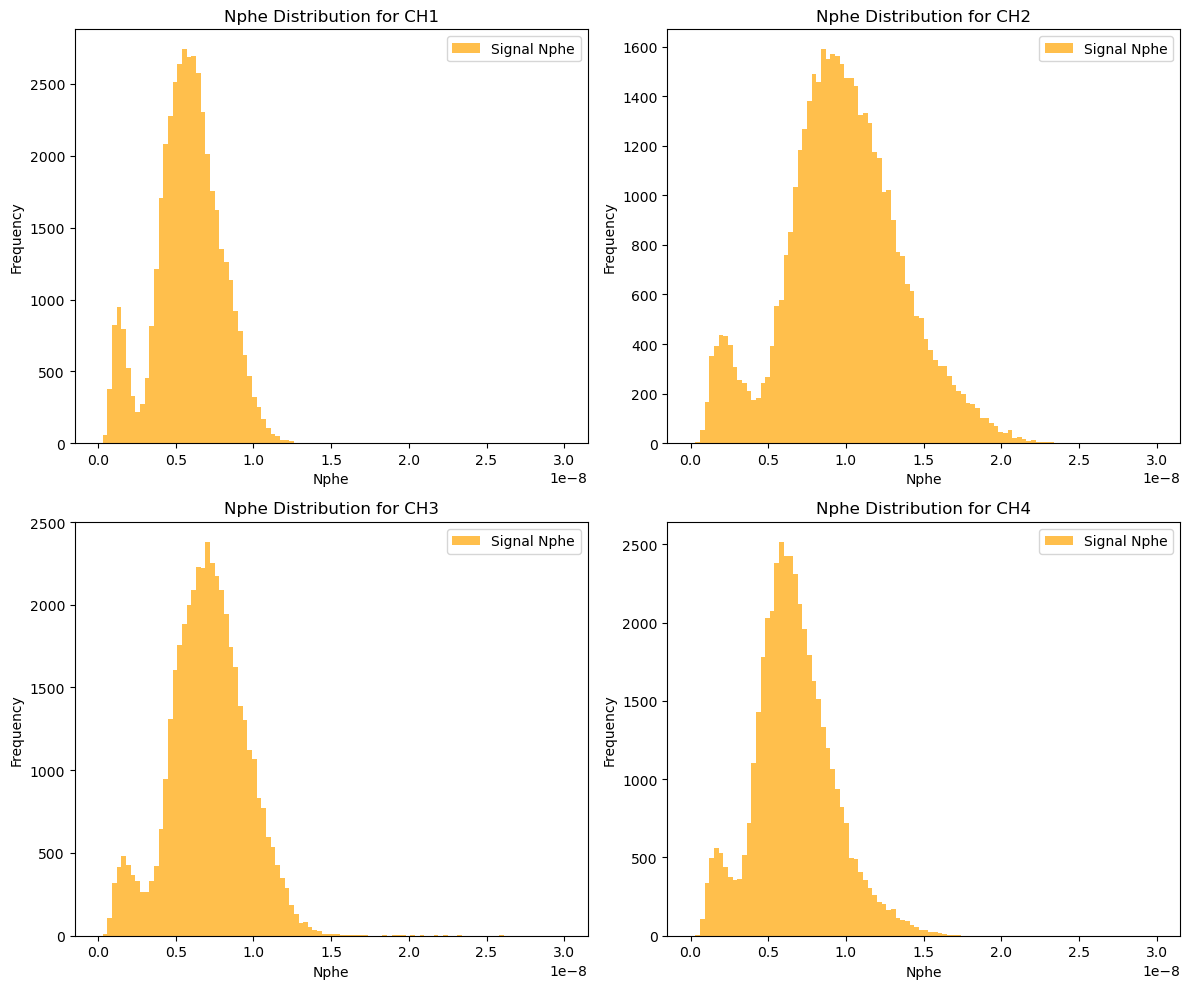

In [10]:
# Define the 4 channels
channels = ['CH1', 'CH2', 'CH3', 'CH4']

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()  # Flatten the 2D array of axes for easy iteration

# Loop through the channels and create a subplot for each
for i, ch in enumerate(channels):
    # Filter the data for the current channel
    sig_data = sum_sig[sum_sig['channel'] == ch]['integral']

    # Plot the signal Nphe distribution
    counts_sig, bins_sig, _ = axs[i].hist(sig_data, bins=100, range=a_range, alpha=0.7, label='Signal Nphe', color='orange', edgecolor='black')

    # Clear the previous background histogram and replot it with the scaled counts
    axs[i].cla()  # Clear the axis before plotting new histograms

    # Replot the signal Nphe distribution
    axs[i].hist(sig_data, bins=100, range=a_range, alpha=0.7, label='Signal Nphe', color='orange')

    # Set titles and labels
    axs[i].set_title(f'Nphe Distribution for {ch}')
    axs[i].set_xlabel('Nphe')
    axs[i].set_ylabel('Frequency')
    #axs[i].set_yscale('log')

    # Add a legend to each subplot
    axs[i].legend()

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.savefig(outplotdir + "WaveformSum_PerChannel.png")
plt.show()

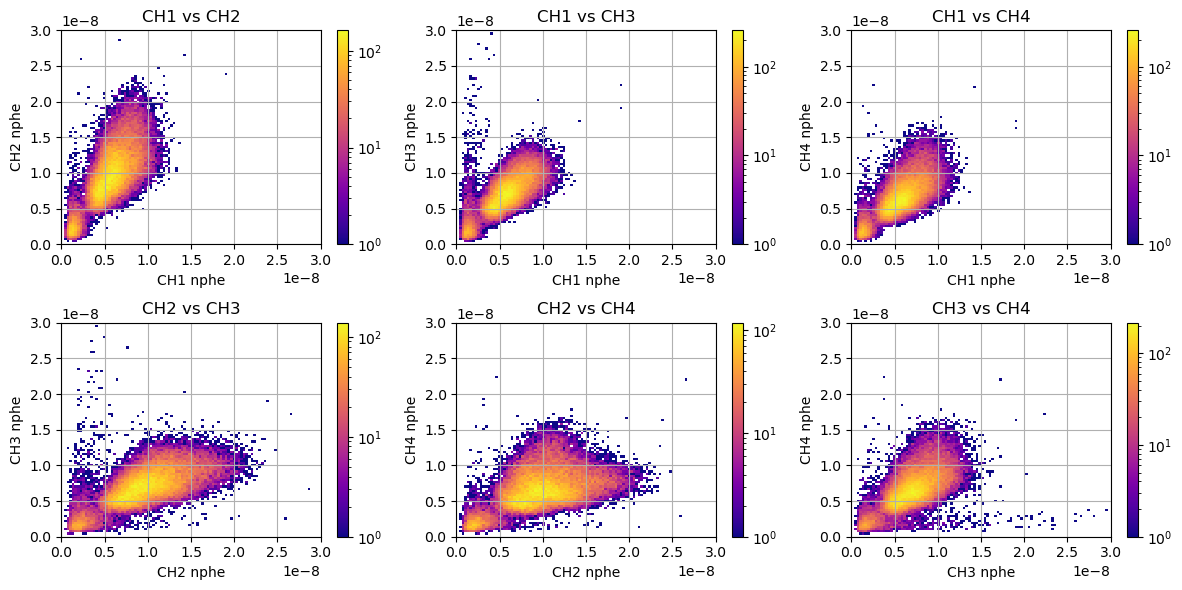

In [11]:
# Filter the DataFrame for each channel
ch1 = sum_sig[sum_sig['channel'] == 'CH1'][['event', 'integral']].rename(columns={'integral': 'CH1'})
ch2 = sum_sig[sum_sig['channel'] == 'CH2'][['event', 'integral']].rename(columns={'integral': 'CH2'})
ch3 = sum_sig[sum_sig['channel'] == 'CH3'][['event', 'integral']].rename(columns={'integral': 'CH3'})
ch4 = sum_sig[sum_sig['channel'] == 'CH4'][['event', 'integral']].rename(columns={'integral': 'CH4'})

# Merge the channel dataframes on 'event'
merged_sum_sig = ch1.merge(ch2, on='event').merge(ch3, on='event').merge(ch4, on='event')

# List to hold channel pairs for correlation
channel_pairs = [('CH1', 'CH2'), ('CH1', 'CH3'), ('CH1', 'CH4'), 
                 ('CH2', 'CH3'), ('CH2', 'CH4'), ('CH3', 'CH4')]

# Create a figure and set of subplots for pairwise plots
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

# Iterate over the channel pairs and create scatter plots
for i, (ch1, ch2) in enumerate(channel_pairs):
    ax = axs[i // 3, i % 3]  # Access subplot
    
    # Create a 2D histogram
    h = ax.hist2d(merged_sum_sig[ch1], merged_sum_sig[ch2], bins=100, range=[a_range,a_range], cmap='plasma', norm=LogNorm())
    
    # Add a colorbar
    plt.colorbar(h[3], ax=ax)
    
    ax.set_xlabel(f'{ch1} nphe')
    ax.set_ylabel(f'{ch2} nphe')
    ax.set_title(f'{ch1} vs {ch2}')
    ax.grid(True)
    #ax.set_xscale('log')
    #ax.set_yscale('log')

plt.savefig(outplotdir+"ChannelNPheCorrelation_Sig.png")
# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

In [12]:
# Group by 'event' and filter only events where all 4 channels are present
events_with_all_channels = sum_sig.groupby('event').filter(lambda x: x['channel'].nunique() == 4)

# Sum the nphes for the channel pairs (CH1 + CH4) and (CH2 + CH3)
ch1_ch4_sums = events_with_all_channels[events_with_all_channels['channel'].isin(['CH1', 'CH4'])].groupby('event')['integral'].sum()
ch2_ch3_sums = events_with_all_channels[events_with_all_channels['channel'].isin(['CH2', 'CH3'])].groupby('event')['integral'].sum()


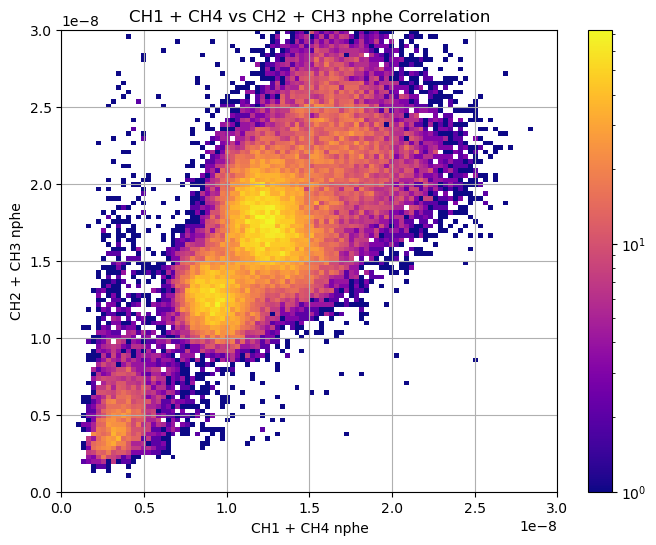

In [13]:
# Now, plot the 2D histogram for CH1 + CH4 vs CH2 + CH3
fig, ax = plt.subplots(figsize=(8, 6))

# Create a 2D histogram with log z-axis scaling
h = ax.hist2d(ch1_ch4_sums, ch2_ch3_sums, bins=100, range=[a_range,a_range], cmap='plasma', norm=LogNorm())

# Add a colorbar with log scaling
plt.colorbar(h[3], ax=ax)

# Set the labels and title
ax.set_xlabel('CH1 + CH4 nphe')
ax.set_ylabel('CH2 + CH3 nphe')
ax.set_title('CH1 + CH4 vs CH2 + CH3 nphe Correlation')

# Display grid
ax.grid(True)

plt.savefig(outplotdir+"2ChannelsNPheCorrelation_Sig.png")

# Show plot
plt.show()

 # Coincidence Anlysis

In [14]:


# Filter based on conditions
filtered_df = df_sig[(df_sig['time'] > -0.5e-7) & (df_sig['time'] < 0)]

# Group by 'event' and check for all channels
valid_events = filtered_df.groupby('event')['channel'].nunique().reset_index()
valid_events = valid_events[valid_events['channel'] == 4]

# List of valid events
result_events = valid_events['event'].tolist()



In [15]:
df_sig_coinc = df_sig[df_sig['event'].isin(result_events) & (df_sig['time'] < 0) & (df_sig['integral'] > 0.1e-8)]
print(df_sig_coinc)

         event channel          time      time_len      integral      ampl  \
3            1     CH1 -3.688500e-08  2.408000e-06  4.279459e-09  0.008876   
32           1     CH2 -1.928500e-08  2.582400e-06  1.142959e-08  0.027865   
50           1     CH3 -2.408500e-08  2.572800e-06  4.355635e-09  0.011537   
71           1     CH4 -4.808500e-08  1.817600e-06  4.545654e-09  0.007388   
892         11     CH1 -1.912500e-08  2.276800e-06  4.662623e-09  0.011366   
...        ...     ...           ...           ...           ...       ...   
3225152  43989     CH4 -2.312500e-08  2.355200e-06  4.215447e-09  0.012521   
3225621  43994     CH1 -4.360500e-08  1.942400e-06  3.971472e-09  0.008626   
3225645  43994     CH2 -2.280500e-08  1.433600e-06  4.441744e-09  0.012680   
3225674  43994     CH3 -2.280500e-08  8.496000e-07  2.879133e-09  0.010860   
3225692  43994     CH4 -2.920500e-08  2.140800e-06  6.098819e-09  0.020655   

         npeaks  is_sat  
3           7.0   False  
32         

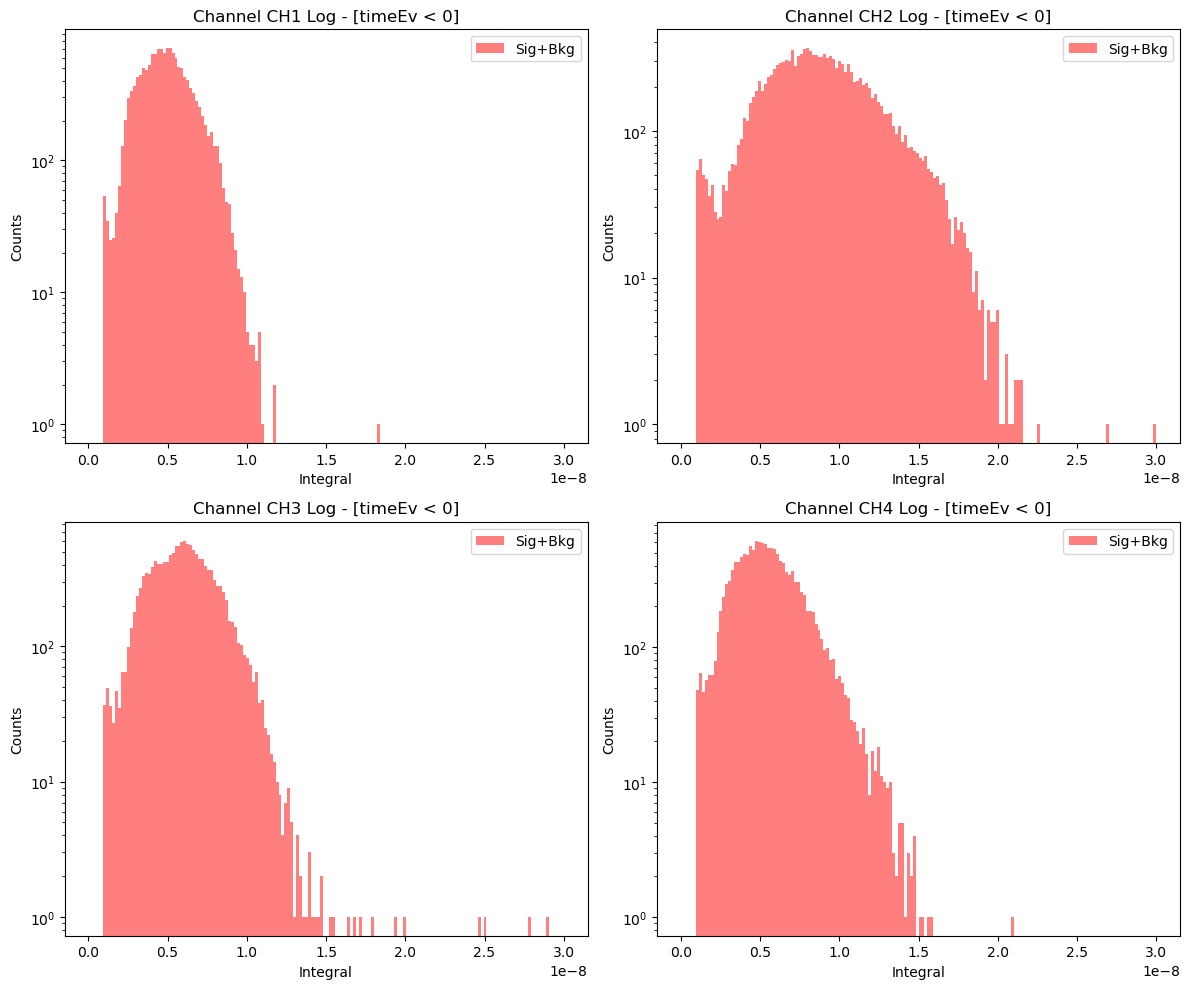

In [16]:
# Unique channels in the data
channels = df_sig_coinc['channel'].unique()
channels = ['CH1','CH2','CH3','CH4']

# Create a figure with 4 subplots (2x2 layout)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Define the number of bins for the histogram
bins = [160, 160, 160, 160]
a_range = [0,3.0e-8]
# Plot for each channel with background and signal superimposed
for i, channel in enumerate(channels):
    ax = axs[i // 2, i % 2]  # Determine the subplot index
    
    # Signal data selection
    channel_data_signal = df_sig_coinc[(df_sig_coinc['channel'] == channel)]
    
    # Compute signal histogram
    counts_signal, bins_sig = np.histogram(channel_data_signal['integral'], bins=bins[i], range=a_range)
    
    # Plot the rescaled signal histogram
    ax.hist(bins_sig[:-1], bins_sig, weights=counts_signal, alpha=0.5, label='Sig+Bkg', color='red')
   
    ax.set_title(f'Channel {channel} Log - [timeEv < 0]')
    ax.set_xlabel('Integral')
    #ax.set_xticks(np.arange(0, 1501, 100))
    ax.set_ylabel('Counts')
    #ax.set_ylim([1e-7,1e-1])
    ax.set_yscale('log')
    ax.legend()

# Adjust layout to prevent overlap and display the plot
plt.savefig(outplotdir+"CoincidenceSpectra_Sig.png")
plt.tight_layout()
plt.show()

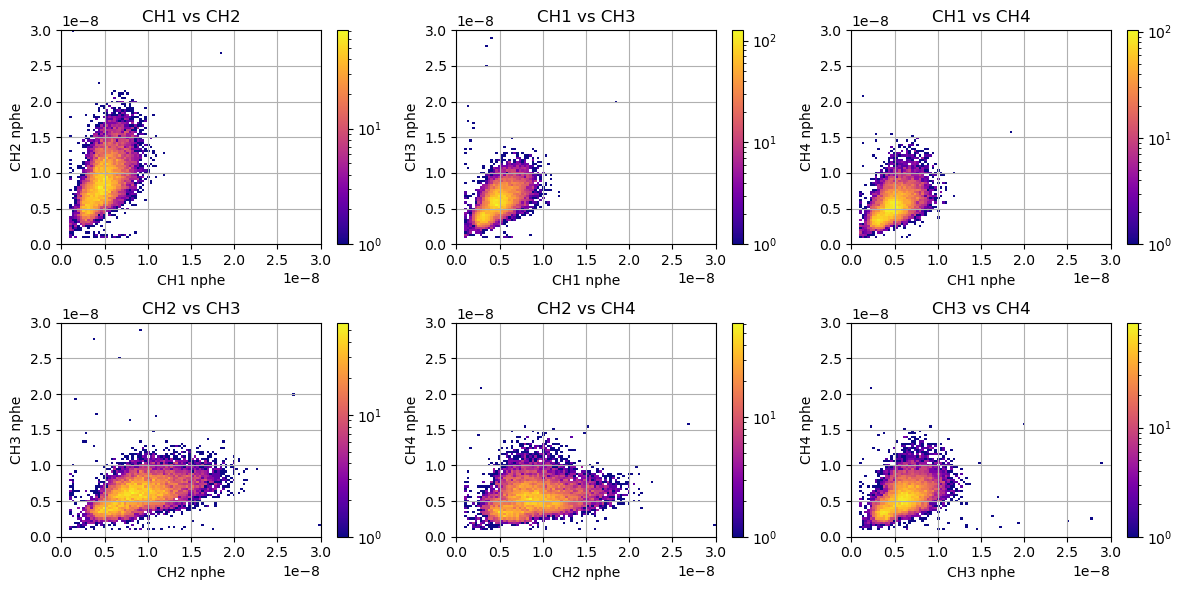

In [17]:
# Filter the DataFrame for each channel
ch1 = df_sig_coinc[df_sig_coinc['channel'] == 'CH1'][['event', 'integral']].rename(columns={'integral': 'CH1'})
ch2 = df_sig_coinc[df_sig_coinc['channel'] == 'CH2'][['event', 'integral']].rename(columns={'integral': 'CH2'})
ch3 = df_sig_coinc[df_sig_coinc['channel'] == 'CH3'][['event', 'integral']].rename(columns={'integral': 'CH3'})
ch4 = df_sig_coinc[df_sig_coinc['channel'] == 'CH4'][['event', 'integral']].rename(columns={'integral': 'CH4'})

# Merge the channel dataframes on 'event'
merged_df_sig_coinc = ch1.merge(ch2, on='event').merge(ch3, on='event').merge(ch4, on='event')

# List to hold channel pairs for correlation
channel_pairs = [('CH1', 'CH2'), ('CH1', 'CH3'), ('CH1', 'CH4'), 
                 ('CH2', 'CH3'), ('CH2', 'CH4'), ('CH3', 'CH4')]

# Create a figure and set of subplots for pairwise plots
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

# Iterate over the channel pairs and create scatter plots
for i, (ch1, ch2) in enumerate(channel_pairs):
    ax = axs[i // 3, i % 3]  # Access subplot
    
    # Create a 2D histogram
    h = ax.hist2d(merged_df_sig_coinc[ch1], merged_df_sig_coinc[ch2], bins=100, range=[a_range,a_range], cmap='plasma', norm=LogNorm())
    
    # Add a colorbar
    plt.colorbar(h[3], ax=ax)
    
    ax.set_xlabel(f'{ch1} nphe')
    ax.set_ylabel(f'{ch2} nphe')
    ax.set_title(f'{ch1} vs {ch2}')
    ax.grid(True)
    #ax.set_xscale('log')
    #ax.set_yscale('log')

plt.savefig(outplotdir+"CoincidenceCorrelationChannels.png")
# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

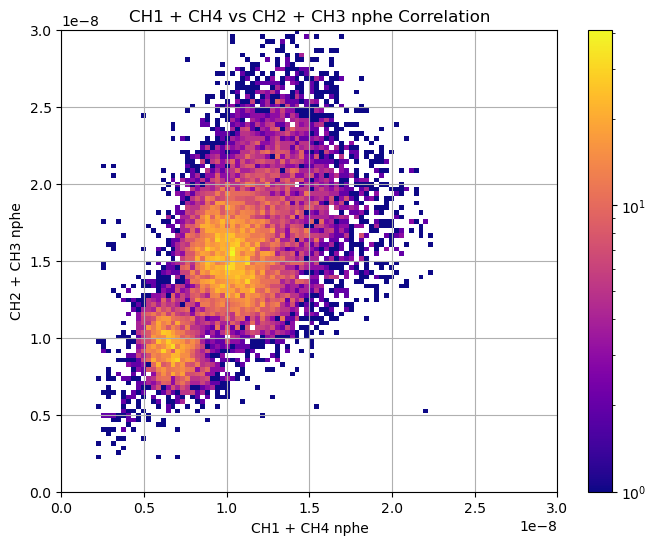

In [18]:
# Group by 'event' and filter only events where all 4 channels are present
events_with_all_channels = df_sig_coinc.groupby('event').filter(lambda x: x['channel'].nunique() == 4)

# Sum the nphes for the channel pairs (CH1 + CH4) and (CH2 + CH3)
ch1_ch4_sums = events_with_all_channels[events_with_all_channels['channel'].isin(['CH1', 'CH4'])].groupby('event')['integral'].sum()
ch2_ch3_sums = events_with_all_channels[events_with_all_channels['channel'].isin(['CH2', 'CH3'])].groupby('event')['integral'].sum()


# Now, plot the 2D histogram for CH1 + CH4 vs CH2 + CH3
fig, ax = plt.subplots(figsize=(8, 6))

# Create a 2D histogram with log z-axis scaling
h = ax.hist2d(ch1_ch4_sums, ch2_ch3_sums, bins=100, range=[a_range,a_range], cmap='plasma', norm=LogNorm())

# Add a colorbar with log scaling
plt.colorbar(h[3], ax=ax)

# Set the labels and title
ax.set_xlabel('CH1 + CH4 nphe')
ax.set_ylabel('CH2 + CH3 nphe')
ax.set_title('CH1 + CH4 vs CH2 + CH3 nphe Correlation')

# Display grid
ax.grid(True)

plt.savefig(outplotdir+"Coincidence2ChCorrelationChannels.png")

# Show plot
plt.show()

In [24]:
CHAmp={
"CH1":535,
"CH2":537,
"CH3":684,
"CH4":675}

ConvPar={
"CH1":(3.03e-8,-6.69e-9),
"CH2":(3.42e-8,-6.28e-9),
"CH3":(4.33e-8,-5.77e-9),
"CH4":(3.98e-8,-8.78e-9)}

def calculate_photoelectrons(integral, p0, p1):
    
    photoelectrons = (integral - p1) / p0
    return photoelectrons

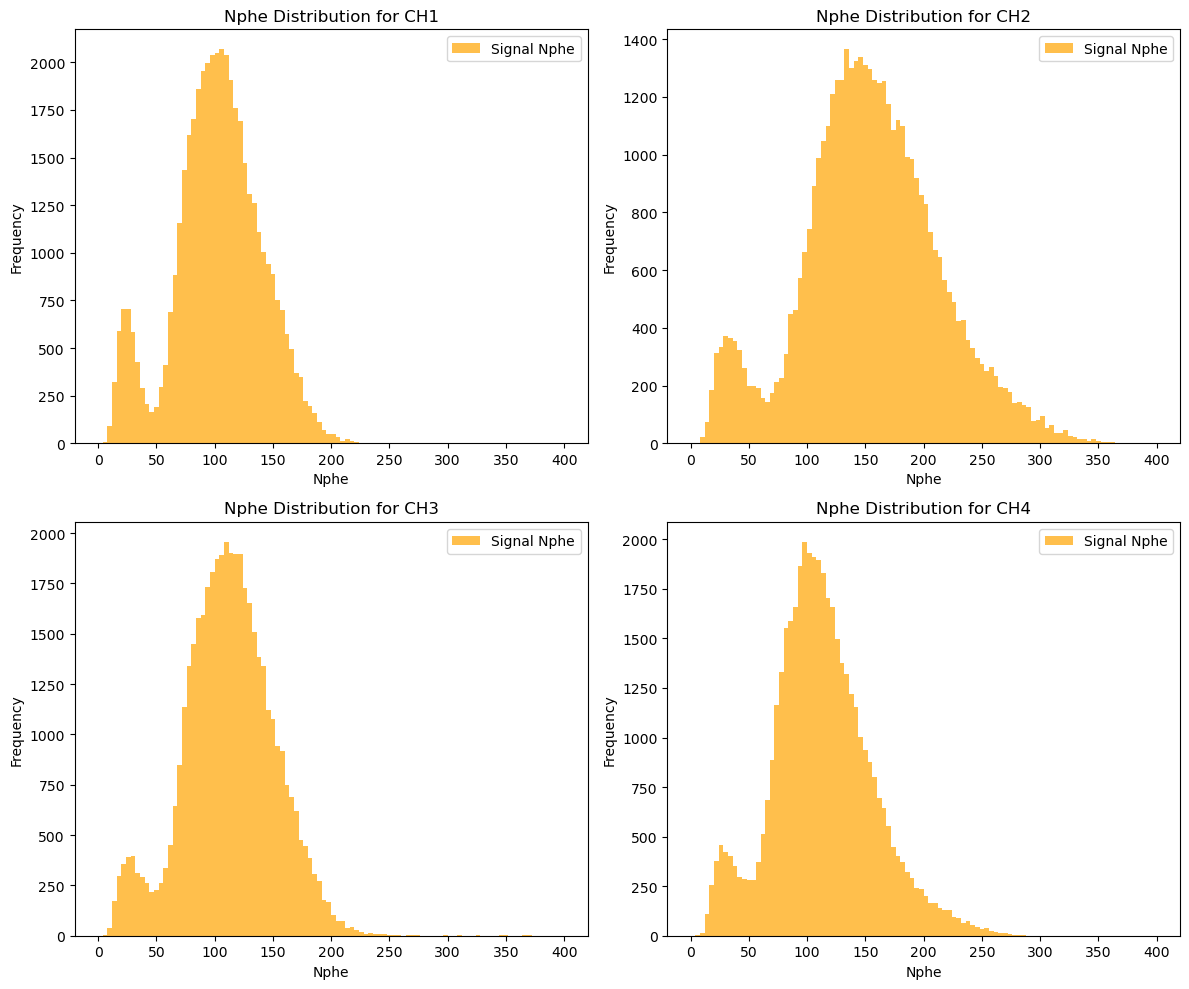

In [25]:
# Define the 4 channels
channels = ['CH1', 'CH2', 'CH3', 'CH4']

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()  # Flatten the 2D array of axes for easy iteration

# Loop through the channels and create a subplot for each
for i, ch in enumerate(channels):
    # Filter the data for the current channel
    sig_data = sum_sig[sum_sig['channel'] == ch]['integral']

    # Convert signal integrals to photoelectrons
    sig_data_photoelectrons = calculate_photoelectrons(sig_data*CHAmp[ch], *ConvPar[ch])
    # Plot the signal Nphe distribution
    counts_sig, bins_sig, _ = axs[i].hist(sig_data_photoelectrons, bins=100, range=[0,400], alpha=0.7, label='Signal Nphe', color='orange', edgecolor='black')

    # Clear the previous background histogram and replot it with the scaled counts
    axs[i].cla()  # Clear the axis before plotting new histograms

    # Replot the signal Nphe distribution
    axs[i].hist(sig_data_photoelectrons, bins=100, range=[0,400], alpha=0.7, label='Signal Nphe', color='orange')

    # Set titles and labels
    axs[i].set_title(f'Nphe Distribution for {ch}')
    axs[i].set_xlabel('Nphe')
    axs[i].set_ylabel('Frequency')
    #axs[i].set_yscale('log')

    # Add a legend to each subplot
    axs[i].legend()

# Adjust layout to avoid overlapping
plt.tight_layout()
plt.savefig(outplotdir + "WaveformSum_PerChannel.png")
plt.show()

In [27]:
sum_sig['photoelectrons'] = sum_sig.apply(lambda row: calculate_photoelectrons(
        row['integral'] * CHAmp[row['channel']], *ConvPar[row['channel']]), axis=1)

df_summed_phe = sum_sig.groupby('event').agg(total_photoelectrons=('photoelectrons', 'sum')).reset_index()

print(df_summed_phe)

        event channel      integral  photoelectrons
0           1     CH1  5.595571e-09       99.020479
1           1     CH2  1.336573e-08      210.049027
2           1     CH3  5.554256e-09       87.872541
3           1     CH4  5.720348e-09       97.236560
4           2     CH1  6.170532e-09      109.172438
...       ...     ...           ...             ...
175995  43999     CH4  3.442622e-09       58.606778
175996  44000     CH1  3.351634e-09       59.399799
175997  44000     CH2  9.269801e-09      145.735757
175998  44000     CH3  5.501563e-09       87.040165
175999  44000     CH4  5.662120e-09       96.249021

[176000 rows x 4 columns]
       event  total_photoelectrons
0          1            494.178607
1          2            493.698324
2          3            517.035442
3          4            498.642822
4          5            536.113234
...      ...                   ...
43995  43996            411.699161
43996  43997            358.104288
43997  43998            402.260828

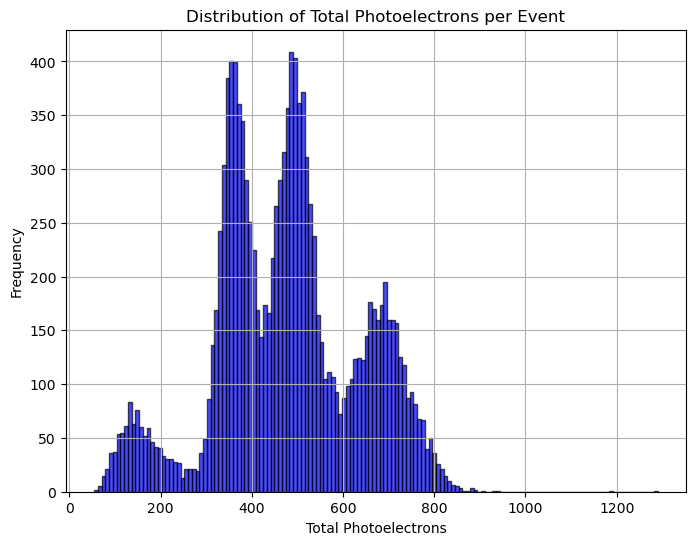

In [50]:
plt.figure(figsize=(8, 6))
plt.hist(df_summed_phe[(df_summed_phe['event']>1000) & (df_summed_phe['event']<14000)]['total_photoelectrons'], bins=150, color='blue', edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Total Photoelectrons')
plt.ylabel('Frequency')
plt.title('Distribution of Total Photoelectrons per Event')

# Display the plot
plt.grid(True)
plt.show()